Build a 2 layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them.


## Auto-Encoder Overview

<img src="http://kvfrans.com/content/images/2016/08/autoenc.jpg" alt="ae" style="width: 800px;"/>


In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("content", one_hot=True)

W0109 23:15:58.277141 140531020990336 deprecation.py:323] From <ipython-input-2-55b8b7b833cf>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0109 23:15:58.281352 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0109 23:15:58.283910 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/contrib/learn/python/learn/datasets/base.py:252: wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instruc

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting content/train-images-idx3-ubyte.gz


W0109 23:15:58.938728 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0109 23:15:58.942044 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting content/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting content/t10k-images-idx3-ubyte.gz


W0109 23:15:59.286634 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/contrib/learn/python/learn/datasets/mnist.py:290: __init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting content/t10k-labels-idx1-ubyte.gz


In [0]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [4]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

W0109 23:16:05.841438 140531020990336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0109 23:16:05.912647 140531020990336 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/training/rmsprop.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.437709
Step 1000: Minibatch Loss: 0.154377
Step 2000: Minibatch Loss: 0.135816
Step 3000: Minibatch Loss: 0.126849
Step 4000: Minibatch Loss: 0.112559
Step 5000: Minibatch Loss: 0.110649
Step 6000: Minibatch Loss: 0.107807
Step 7000: Minibatch Loss: 0.102935
Step 8000: Minibatch Loss: 0.093102
Step 9000: Minibatch Loss: 0.093840
Step 10000: Minibatch Loss: 0.086848
Step 11000: Minibatch Loss: 0.089042
Step 12000: Minibatch Loss: 0.082047
Step 13000: Minibatch Loss: 0.080825
Step 14000: Minibatch Loss: 0.077849
Step 15000: Minibatch Loss: 0.075333
Step 16000: Minibatch Loss: 0.074197
Step 17000: Minibatch Loss: 0.071554
Step 18000: Minibatch Loss: 0.070048
Step 19000: Minibatch Loss: 0.071036
Step 20000: Minibatch Loss: 0.067281
Step 21000: Minibatch Loss: 0.069774
Step 22000: Minibatch Loss: 0.065211
Step 23000: Minibatch Loss: 0.063950
Step 24000: Minibatch Loss: 0.065122
Step 25000: Minibatch Loss: 0.062326
Step 26000: Minibatch Loss: 0.059715
Step 27000: Mi

Original Images


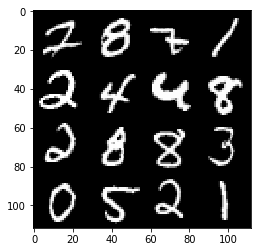

Reconstructed Images


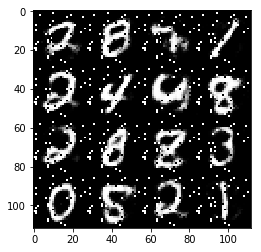

In [7]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={X: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()